# Things to install

## Colab

In [ ]:
!apt update && apt install -y openslide-tools
!pip install openslide-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Locale

In [ ]:
!pip install openslide-python
!pip install opencv-python
!pip install imgaug
!pip install scikit-learn

In [ ]:
!pip install scikit-learn

In [1]:
# The path can also be read from a config file, etc.
OPENSLIDE_PATH = r'C:\Users\sofia\openslide-win64-20230414\openslide-win64-20230414\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

# Code

## Functions

In [6]:
def get_annotatios(file_path):
    # Parsa il file XML delle annotazioni
    tree = ET.parse(file_path)
    root = tree.getroot()
    # Ottieni tutte le annotazioni dal file XML
    annotations = []
    for annotation in root.iter('Annotation'):
        name = annotation.get('Name')
        coordinates = []
        for coordinate in annotation.iter('Coordinate'):
            x = float(coordinate.get('X'))
            y = float(coordinate.get('Y'))
            coordinates.append((x, y))
        annotations.append({'name': name, 'coordinates': coordinates})
    return annotations


In [7]:
def is_mostly_white(image, threshold_w=0.85, threshold_p = 0.98):
    # Converti l'immagine in scala di grigi
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcola la soglia per considerare i pixel bianchi
    pixel_threshold = int(threshold_w * 255)

    # Conta i pixel bianchi nell'immagine
    white_pixels = np.sum(gray_image >= pixel_threshold)

    # Calcola la percentuale di pixel bianchi rispetto alla dimensione totale dell'immagine
    white_percentage = white_pixels / (gray_image.shape[0] * gray_image.shape[1])

    # Verifica se la percentuale di pixel bianchi supera la soglia
    if white_percentage >= threshold_p:
        return True, white_percentage
    else:
        return False, white_percentage

In [8]:
def get_labels(labels, annotations):
    for annotation in annotations:
        polygon = np.array([annotation['coordinates']], dtype=np.int32)
        cv2.fillPoly(labels, polygon, 1)

In [9]:
def plt_image_labels(image, labes):
    fig, axs = plt.subplots(1, 2)
    # Primo subplot: labels
    axs[0].imshow(labes)
    axs[0].axis('off')
    # Secondo subplot: immagine
    axs[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    # Mostra i subplot affiancati
    plt.show()

In [95]:
def plt_image_image(imageA, imageB):
    fig, axs = plt.subplots(1, 2)
    # Primo subplot: labels
    axs[0].imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title("originale")
    # Secondo subplot: immagine
    print(imageB.shape)
    axs[1].imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    axs[1].set_title("modificata")
    # Mostra i subplot affiancati
    plt.show()

In [4]:
def plt_image(image, labels):

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Sovrapposizione punti con labels=1
    overlay = np.zeros_like(image)
    overlay[np.where(labels == 1)] = [128, 128, 0]  # Giallo (BGR)
    #overlay[np.where(labels == 0)] = [255, 255, 255]  # Giallo (BGR)
    
    alpha = 0.8  # Livello di trasparenza
    overlay = cv2.addWeighted(image, 1, overlay, alpha, 0)

    plt.imshow(overlay)  # Sovrapposizione con trasparenza
    plt.show()

In [5]:
def data_augment(image):
    image_90 = np.rot90(image)
    image_180 = np.rot90(image_90)
    image_270 = np.rot90(image_180)
    return image_90, image_180, image_270

## 'Main'

In [42]:
# Carica l'immagine svs
wsi = openslide.OpenSlide(path_to_image)
# Ottieni le dimensioni dell'immagine
w, h = wsi.dimensions
# Calcola il numero di righe e colonne necessarie per suddividere l'immagine
num_rows = h // output_height
num_cols = w // output_width

In [43]:
print(num_rows, num_cols)

37 88


In [44]:
annotations = get_annotatios(path_to_xml)
# Crea un'immagine di output con le stesse dimensioni dell'immagine svs
label_image = np.zeros((h, w), dtype=np.uint8)
get_labels(label_image, annotations)

In [57]:
dataset = []
labels = []

#for row in range(num_rows):
#    for col in range(num_cols):
for row in range(3, 5):
    for col in range(58, 60):
        # Calcola le coordinate di inizio e fine per l'immagine corrente
        x = col * output_width
        y = row * output_height
        x_end = x + output_width
        y_end = y + output_height
        
        # Estrai l'immagine corrente
        region = wsi.read_region((x, y), 0, (output_width, output_height))
        image = cv2.cvtColor(np.array(region), cv2.COLOR_RGBA2BGR)
        
        is_white, p = is_mostly_white(image)
        if not is_white:
            if not ((col == num_cols-1) or (row == num_rows-1)):
                x_h = x + output_width // 2 
                x_v = x
                x_d = x + output_width // 2 
                y_h = y
                y_v = y + output_height // 2
                y_d = y + output_width // 2 
                region_h = wsi.read_region((x_h, y_h), 0, (output_width, output_height))
                region_v = wsi.read_region((x_v, y_v), 0, (output_width, output_height))
                region_d = wsi.read_region((x_d, y_d), 0, (output_width, output_height))
                image_h = cv2.cvtColor(np.array(region_h), cv2.COLOR_RGBA2BGR)
                image_v = cv2.cvtColor(np.array(region_v), cv2.COLOR_RGBA2BGR)
                image_d = cv2.cvtColor(np.array(region_d), cv2.COLOR_RGBA2BGR)
                is_white_h, _ = is_mostly_white(image_h)
                is_white_v, _ = is_mostly_white(image_v)
                is_white_d, _ = is_mostly_white(image_d)
                if not is_white_h:
                    dataset.append(image_h)
                    labels.append(label_image[y_h: y_h+output_height, x_h: x_h+output_width])
                if not is_white_v:
                    dataset.append(image_v)
                    labels.append(label_image[y_v: y_v+output_height, x_v: x_v+output_width])
                if not is_white_d:
                    dataset.append(image_d)
                    labels.append(label_image[y_d: y_d+output_height, x_d: x_d+output_width])
            dataset.append(image)
            labels.append(label_image[y:y_end, x: x_end])
dataset = np.array(dataset)
labels = np.array(labels)

In [58]:
dataset.shape

(16, 2000, 2000, 3)

In [ ]:
for i in range(len(dataset)):
  plt_image(dataset[i], labels[i])

In [14]:
np.save('dataset.npy', dataset)

In [11]:
data = np.load('dataset.npy')
data.shape

(28, 2000, 2000, 3)

In [8]:
x = np.sum(data)
x

0

In [24]:
model = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(400, 400),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.25),
  tf.keras.layers.RandomBrightness((-0.2, 0.2))
  tf.keras.layers.RandomContrast((-0.2, 0.2))
  tf.keras.layers.Rescaling(1./255)
])

In [14]:
data = np.load("../dataset/slides/dataset.npy")
labels = np.load("../dataset/annotations/labels.npy")

In [16]:
data[0].shape

(400, 400, 3)

In [98]:
def plt_image_image(imageA, imageB):
    fig, axs = plt.subplots(1, 2)
    # Primo subplot: labels
    axs[0].imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title("originale")
    # Secondo subplot: immagine
    print(imageB.shape)
    axs[1].imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    axs[1].set_title("modificata")
    # Mostra i subplot affiancati
    plt.show()

In [ ]:

for i in range(1):
    image = data[352]
    #grayscaled = np.array(tf.image.rgb_to_grayscale(image))
    #plt_image_image(image, grayscaled)
    ## TRANSFORMARE GRAYSCALED
    #
    #saturated = np.array(tf.image.adjust_saturation(image, 3))
    #plt_image_image(image, saturated)
    #
    #bright = np.array(tf.image.adjust_brightness(image, 0.1))
    #plt_image_image(image, bright)
    #
    #dark = np.array(tf.image.adjust_brightness(image, -0.2))
    #plt_image_image(image, dark)
    #
    cropped = tf.image.central_crop(image, central_fraction=0.5)
    #cropped = np.array(resize(cropped)).astype(int)
    cropped = np.int32(cropped)

    
    plt_image_image(image, cropped)
    #print(cropped.shape)
    #dataset=np.append(dataset, [saturated, bright, cropped], axis=0)

In [ ]:
for i in range(len(dataset)):
    # Primo subplot: labels
    # Secondo subplot: immagine
    plt.imshow(cv2.cvtColor(dataset[i], cv2.COLOR_BGR2RGB))
    # Mostra i subplot affiancati
    plt.show()

In [ ]:
import random

data = np.load("../dataset/slides/dataset.npy")
labels = np.load("../dataset/annotations/labels.npy")

for i in range(100):
    index = random.randint(0, len(data))
    print(index)
    plt_image(data[index], labels[index])

In [11]:
data = np.load("../dataset/slides/dataset.npy")
labels = np.load("../dataset/annotations/labels.npy")

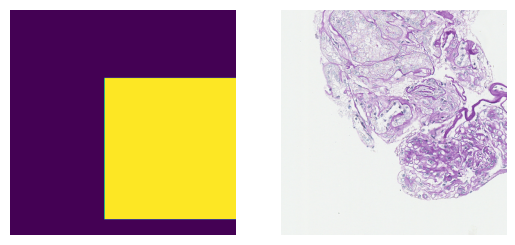

In [12]:
plt_image_labels(data[743], labels[743])

# Tensorflow

In [111]:
model = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(400, 400),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.25),
  tf.keras.layers.RandomBrightness((-0.2, 0.2)),
  tf.keras.layers.RandomContrast(0.3),
])

rescaling = tf.keras.layers.Rescaling(1./255)

In [ ]:
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(400, 400),
])



In [6]:
data = np.load("../dataset/slides/dataset.npy")
labels = np.load("../dataset/annotations/labels.npy")

In [105]:
train_dataset = tf.data.Dataset.from_tensor_slices((data, labels))


## Data augmentation and Plot

In [5]:
import imgaug.augmenters as iaa
import imgaug as ia
import imageio
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

In [17]:
print(data.shape)
print(labels.shape)

(7271, 400, 400, 3)
(7271, 400, 400)


In [246]:
image = data[568]
label = SegmentationMapsOnImage(labels[568], shape=data[1].shape)

images_aug = []
segmaps_aug = []
da = data_augment()
for _ in range(4):
    images_aug_i, segmaps_aug_i = da(image=image, segmentation_maps=label)
    images_aug.append(images_aug_i)
    segmaps_aug.append(segmaps_aug_i)
    
cells = []
for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    #cells.append(image)                                         # column 1
    cells.append(label.draw_on_image(image)[0])                  # column 2
    #cells.append(image_aug)                                     # column 3
    cells.append(segmap_aug.draw_on_image(image_aug)[0])         # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2])[0])   # column 5

# Convert cells to a grid image and save.
grid_image = ia.draw_grid(cells, cols=3)
imageio.imwrite("example_segmaps.jpg", grid_image)

In [6]:

def data_augment():
    return iaa.Sequential([
        iaa.Dropout((0, 0.05)),      # drop 5% or 20% of all pixels
        # rotate by -45 to 45 degrees (affects segmaps)
        iaa.Affine(rotate=(-30, 30)),
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.2), keep_size=True),
        iaa.WithBrightnessChannels(iaa.Add((-50, 50))),
        iaa.Grayscale(alpha=(0.0, 0.5)),
        iaa.GammaContrast((0.5, 2.0), per_channel=True),
        iaa.PiecewiseAffine(scale=(0.01, 0.1)),
    ], random_order=True)


## SegNet

In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [5]:
tf.compat.v1.enable_eager_execution()

In [8]:
da = data_augment()

In [13]:
data = np.load("../dataset/slides/dataset.npy")
labels = np.load("../dataset/annotations/labels.npy")
data.shape

(7271, 400, 400, 3)

In [21]:
labelsx =[SegmentationMapsOnImage(label, shape=data[1].shape) for label in labels[0:50]]
x = np.array([segmap.get_arr() for segmap in labelsx])

In [22]:
x.shape

(50, 400, 400)

In [23]:
labelsx = [SegmentationMapsOnImage(label, shape=data[1].shape) for label in labels[0:50]]
datax = data[0:50].copy()
for _ in range(1):
    images, labels_a = da(images=datax[0:50], segmentation_maps=labelsx)
    data = np.append(data, images, axis = 0)
    labels = np.append(labels, np.array([label.get_arr() for label in labels_a]), axis = 0)
print(data.shape)
print(labels.shape)
    


(7321, 400, 400, 3)
(7321, 400, 400)


In [9]:
image_train, image_test, label_train, label_test = train_test_split(data, labels, test_size=0.25, random_state=42)
train_data = tf.data.Dataset.from_tensor_slices((image_train, label_train))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [265]:
image_train, image_test, label_train, label_test = train_test_split(data[0:50], labels[0:50], test_size=0.25, random_state=42)

In [266]:
train_data = tf.data.Dataset.from_tensor_slices((image_train, label_train))

In [263]:
x= np.concatenate([x for x, y in train_data], axis=0)

In [ ]:
da = data_augment()

def process_d (image, label):
    sess = tf.Session()
    with sess.as_default():
        tensor_array = image.eval(session=sess)
        print(tensor_array)
    #image, label = da(image=image, segmentation_maps=label)
    #return tf.convert_to_tensor(image), tf.convert_to_tensor(label)

inputs = train_data.map(process_d, num_parallel_calls=tf.data.AUTOTUNE)